## Practical project 1 - 02 - Model search - baseline selection

Explainable Automated Machine Learning course, LTAT.02.023
University of Tartu, Institute of Computer Science

Each team will work on a machine learning problem from end-to-end.

#### Project's general description:
<details>
  <summary>Click here for more information!</summary>

  Each team will work on a machine learning problem from end-to-end.

  **Step 1:** Choose a dataset. Build and train a baseline for comparison. To construct the baseline you do the following:
  * Try a set of possible machine learning algorithms (**13 algorithms**) using their **default hyperparameters** and choose the one with the highest performance for comparison.


  **Step 2:** Based on the problem at hand, you study:
  * the **potential pipeline structure**,
  * **algorithms**
  * or **feature transformers** at each step,
  * **hyper-parameters ranges**.
  
  Use hyperOpt with the potential search space to beat the baseline.


  **Step 3:** Monitor the performance of the constructed pipeline from the previous step across different time budgets (number of iterations) and report the least time budget that you are able to outperform the baseline.


  **Step 4:** Determine whether the difference in performance between the constructed pipeline and the baseline is statistically significant.

</details>

#### Dataset used:
<details>
  <summary>Click here for more information!</summary>

  Dataset is taken from Kaggle competition - Drinking Water Quality Prediction. The goal of the competition is to create a model that predicts the water quality in Estonian water stations based on the government's open data of the previous measurements.

  [Reference](https://www.kaggle.com/competitions/copy-of-drinking-water-quality)
</details>

</details>

#### References:
<details>
  <summary>Click here for more information!</summary>

  [MLJ for Data Scientists in Two Hours](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/telco/)
</details>

### Activate the current project. Check the packages available

In [1]:
using Pkg

Pkg.activate(".")
Pkg.status()


  Activating project at `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1`


Status `/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1/Project.toml`
  [336ed68f] CSV v0.10.7
  [324d7699] CategoricalArrays v0.10.7
  [af321ab8] CategoricalDistributions v0.1.9
  [861a8166] Combinatorics v1.0.2
⌃ [a93c6f00] DataFrames v1.3.6
⌃ [add582a8] MLJ v0.18.6
  [c6f25543] MLJDecisionTreeInterface v0.2.5
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.0
  [17a086e9] MLJParticleSwarmOptimization v0.1.2
  [5ae90465] MLJScikitLearnInterface v0.2.0
  [54119dfa] MLJXGBoostInterface v0.2.1
  [eff96d63] Measurements v2.8.0
⌃ [91a5bcdd] Plots v1.35.7
  [860ef19b] StableRNGs v1.0.0
  [fd094767] Suppressor v0.2.1
Info Packages marked with ⌃ have new versions available and may be upgradable.


### Get packages to use

In [2]:
using DataFrames
using CSV
using MLJ
using Random
using Plots

using MLJScikitLearnInterface
using MLJDecisionTreeInterface
using MLJXGBoostInterface

include("./helper.jl")
using .Helper

### Get adjusted datasets

In [6]:
df_train = CSV.read(joinpath(@__DIR__, "data/adjusted/train_adjusted.csv"), delim=';', DataFrame)
display(first(df_train, 3))
df_test = CSV.read(joinpath(@__DIR__, "data/adjusted/test_adjusted.csv"), delim=';', DataFrame)
display(first(df_test, 3))

,aluminium,ammonium,boron,chloride,coli-like-bacteria-colilert,coli-like-bacteria
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,missing,0.05,missing,missing,missing,0.0
2,missing,0.05,missing,missing,missing,0.0
3,missing,0.05,missing,missing,missing,0.0


,aluminium,ammonium,boron,chloride,coli-like-bacteria-colilert,coli-like-bacteria
,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,5.0,0.08,0.071,130.0,missing,0.0
2,missing,0.08,missing,missing,missing,0.0
3,missing,missing,missing,112.0,missing,missing


### Adjust the scientific data types

#### View the initiall set scientific data types

In [22]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,Type,Type
1,aluminium,"Union{Missing, Continuous}","Union{Missing, Float64}"
2,ammonium,"Union{Missing, Continuous}","Union{Missing, Float64}"
3,boron,"Union{Missing, Continuous}","Union{Missing, Float64}"
4,chloride,"Union{Missing, Continuous}","Union{Missing, Float64}"
5,coli-like-bacteria-colilert,"Union{Missing, Continuous}","Union{Missing, Float64}"
6,coli-like-bacteria,"Union{Missing, Continuous}","Union{Missing, Float64}"
7,colony-count-at-22-c,"Union{Missing, Continuous}","Union{Missing, Float64}"
8,color-pt-co-unit,"Union{Missing, Continuous}","Union{Missing, Float64}"
9,color-pt/co-scale,"Union{Missing, Continuous}","Union{Missing, Float64}"


#### Adjust the scientific data types adn change target column's levels

* change scientific data type for taget column 'compliance': Count -> OrderedFactor
* adjust appropriate levels: negative one (1) should be first

In [8]:
coerce!(df_train, Float64 => Continuous)
# change scientific data type for taget column 'compliance': Count -> OrderedFactor
coerce!(df_train, :compliance => OrderedFactor)
# adjust appropriate levels: negative one (1) should be first
levels!(df_train.compliance, [1, 0])
levels(df_train.compliance)

2-element Vector{Int64}:
 1
 0

#### View the adjusted scientific data types

In [13]:
schema(df_train) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,Type,Type
1,aluminium,"Union{Missing, Continuous}","Union{Missing, Float64}"
2,ammonium,"Union{Missing, Continuous}","Union{Missing, Float64}"
3,boron,"Union{Missing, Continuous}","Union{Missing, Float64}"
4,chloride,"Union{Missing, Continuous}","Union{Missing, Float64}"
5,coli-like-bacteria-colilert,"Union{Missing, Continuous}","Union{Missing, Float64}"
6,coli-like-bacteria,"Union{Missing, Continuous}","Union{Missing, Float64}"
7,colony-count-at-22-c,"Union{Missing, Continuous}","Union{Missing, Float64}"
8,color-pt-co-unit,"Union{Missing, Continuous}","Union{Missing, Float64}"
9,color-pt/co-scale,"Union{Missing, Continuous}","Union{Missing, Float64}"


### Adjust 'missing' values

In [27]:
imputer = FillImputer()
mach = machine(imputer, df_train) |> fit!
_df_train = MLJ.transform(mach, df_train)
schema(_df_train) |> DataFrames.DataFrame

┌ Info: Training machine(FillImputer(features = Symbol[], …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


In [28]:
imputer = FillImputer()
mach = machine(imputer, df_test) |> fit!
_df_test = MLJ.transform(mach, df_test)
schema(_df_test) |> DataFrames.DataFrame

┌ Info: Training machine(FillImputer(features = Symbol[], …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


,names,scitypes,types
,Symbol,DataType,DataType
1,aluminium,Continuous,Float64
2,ammonium,Continuous,Float64
3,boron,Continuous,Float64
4,chloride,Continuous,Float64
5,coli-like-bacteria-colilert,Continuous,Float64
6,coli-like-bacteria,Continuous,Float64
7,colony-count-at-22-c,Continuous,Float64
8,color-pt-co-unit,Continuous,Float64
9,color-pt/co-scale,Continuous,Float64


### Save 'cleaned' train/test dataset

In [35]:
CSV.write(joinpath(@__DIR__, "data/clean/train_clean.csv"), delim=';', _df_train)
CSV.write(joinpath(@__DIR__, "data/clean/test_clean.csv"), delim=';', _df_test)

"/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1/data/clean/test_clean.csv"

### Split the data "horizontally" into input and target parts

In [36]:
y, X = unpack(_df_train, ==(:compliance); rng=123)
first(X, 3) |> pretty

┌────────────┬────────────┬────────────┬────────────┬─────────────────────────────┬────────────────────┬──────────────────────┬──────────────────┬───────────────────┬─────────────────────────┬─────────────┬───────────────────────────┬──────────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────────────────────┬─────────────┬──────────────────┬────────────┬────────────┬──────────────────┬───────────────────────┬───────────────┬────────────┐
│ aluminium  │ ammonium   │ boron      │ chloride   │ coli-like-bacteria-colilert │ coli-like-bacteria │ colony-count-at-22-c │ color-pt-co-unit │ color-pt/co-scale │ electrical-conductivity │ enterococci │ escherichia-coli-colilert │ escherichia-coli │ fluoride   │ iron       │ manganese  │ nitrate    │ nitrite    │ odour-dilution-level │ oxidability │ smell-ball-units │ sodium     │ sulphate   │ taste-ball-units │ taste-dilution-degree │ turbidity-ntu │ ph         │
│ Float64    │ Float64    │ Float64    │ Float64    │ 

### Search for models

In [37]:
show(stdout, "text/plain", models(matching(X, y)))

51-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 

(name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DSADDetector, package_name = OutlierDetectionNetworks, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = DummyClassifier, package_name = ScikitLearn, ... )
 (name = ESADDetector, package_name = OutlierDetectionNetworks, ... )
 (name = EvoTreeClassifier, package_name = EvoTrees, ... )
 

(name = ExtraTreesClassifier, package_name = ScikitLearn, ... )
 (name = GaussianNBClassifier, package_name = NaiveBayes, ... )
 (name = GaussianNBClassifier, package_name = ScikitLearn, ... )
 (name = GaussianProcessClassifier, package_name = ScikitLearn, ... )
 (name = GradientBoostingClassifier, package_name = ScikitLearn, ... )
 (name = KNNClassifier, package_name = NearestNeighborModels, ... )
 (name = KNeighborsClassifier, package_name = ScikitLearn, ... )
 (name = KernelPerceptron, package_name = BetaML, ... )
 (name = LDA, package_name = MultivariateStats, ... )
 (name = LGBMClassifier, package_name = LightGBM, ... )
 (name = LinearBinaryClassifier, package_name = GLM, ... )
 (name = LinearPerceptron, package_name = BetaML, ... )
 (name = LinearSVC, package_name = LIBSVM, ... )
 (name = LogisticCVClassifier, package_name = ScikitLearn, ... )
 (name = LogisticClassifier, package_name = MLJLinearModels, ... )
 (name = LogisticClassifier, package_name = ScikitLearn, ... )
 (name =

(name = PerceptronClassifier, package_name = ScikitLearn, ... )
 (name = ProbabilisticSGDClassifier, package_name = ScikitLearn, ... )
 (name = RandomForestClassifier, package_name = BetaML, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )
 (name = RandomForestClassifier, package_name = ScikitLearn, ... )
 (name = RidgeCVClassifier, package_name = ScikitLearn, ... )
 (name = RidgeClassifier, package_name = ScikitLearn, ... )
 (name = SGDClassifier, package_name = ScikitLearn, ... )
 (name = SVC, package_name = LIBSVM, ... )
 (name = SVMClassifier, package_name = ScikitLearn, ... )
 (name = SVMLinearClassifier, package_name = ScikitLearn, ... )
 (name = SVMNuClassifier, package_name = ScikitLearn, ... )
 (name = SubspaceLDA, package_name = MultivariateStats, ... )
 

(name = XGBoostClassifier, package_name = XGBoost, ... )

### The models selection made:

1. AdaBoostClassifier, package_name = ScikitLearn
2. BaggingClassifier, package_name = ScikitLearn
3. BayesianLDA, package_name = ScikitLearn
4. DecisionTreeClassifier, package_name = DecisionTree
5. GaussianNBClassifier, package_name = ScikitLearn
6. KNeighborsClassifier, package_name = ScikitLearn
7. LogisticClassifier, package_name = ScikitLearn
8. GaussianProcessClassifier, package_name = ScikitLearn
9. ProbabilisticSGDClassifier, package_name = ScikitLearn
10. RandomForestClassifier, package_name = ScikitLearn
11. BayesianQDA, package_name = ScikitLearn
12. DummyClassifier, package_name = ScikitLearn
13. XGBoostClassifier, package_name = XGBoost

### Looking for **baseline**

#### Dataset partition on train/validation

In [38]:
train, validation = partition(1:length(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  607, 608, 609, 610, 611, 612, 613, 614, 615, 616], [617, 618, 619, 620, 621, 622, 623, 624, 625, 626  …  871, 872, 873, 874, 875, 876, 877, 878, 879, 880])

#### 1. AdaBoostClassifier, package_name=ScikitLearn: parameters + evaluation

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


import MLJScikitLearnInterface ✔
AdaBoostClassifier

(
  base_estimator = nothing, 
  n_estimators = 50, 
  learning_rate = 1.0, 
  algorithm = "

SAMME.R", 
  random_state = nothing)

┌ Info: Training machine(AdaBoostClassifier(base_estimator = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("AdaBoostClassifier", 0.257, 0.955, 0.966)


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     51      │      5      │
├─────────────┼─────────────┼─────────────┤
│      0      │      4      │     204     │
└─────────────┴─────────────┴─────────────┘


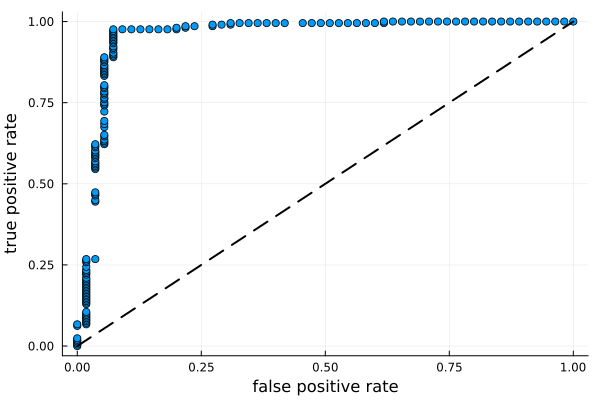

In [39]:
AdaBoostClassifier = @load AdaBoostClassifier pkg=ScikitLearn
_machine = Helper.get_machine(AdaBoostClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_1 = Helper.get_measurements("AdaBoostClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_1)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 2. BaggingClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BaggingClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  base_estimator = nothing, 
  n_estimators = 10, 
  max_samples = 1.0, 
  max_features = 1.0, 
  bootstrap = true, 
  bootstrap_features = false, 
  oob_score = false, 
  warm_start = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0)

┌ Info: Training machine(BaggingClassifier(base_estimator = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("BaggingClassifier", 0.036, 0.977, 0.981)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     51      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │      4      │     208     │
└─────────────┴─────────────┴─────────────┘


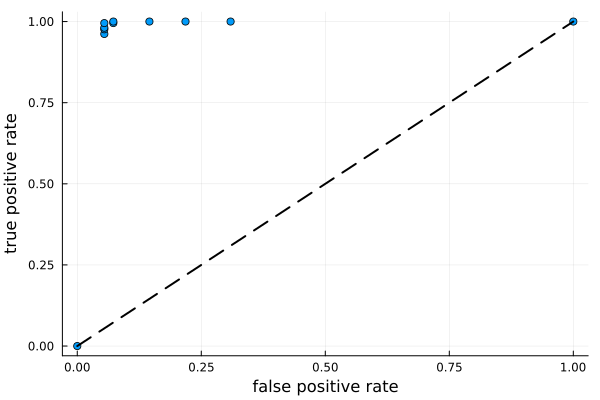

In [40]:
BaggingClassifier = @load BaggingClassifier pkg=ScikitLearn
_machine = Helper.get_machine(BaggingClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_2 = Helper.get_measurements("BaggingClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_2)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 3. BayesianLDA, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BayesianLDA

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  solver = "svd", 
  shrinkage = nothing, 
  priors = nothing, 
  n_components = nothing, 
  store_covariance = false, 
  tol = 0.0001)

┌ Info: Training machine(BayesianLDA(solver = svd, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("BayesianLDA", 0.253, 0.84, 0.848)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     17      │      2      │
├─────────────┼─────────────┼─────────────┤
│      0      │     38      │     207     │
└─────────────┴─────────────┴─────────────┘


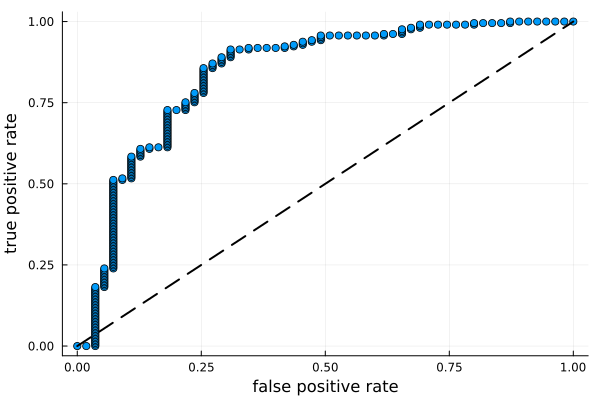

In [41]:
BayesianLDA = @load BayesianLDA pkg=ScikitLearn
_machine = Helper.get_machine(BayesianLDA(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_3 = Helper.get_measurements("BayesianLDA", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_3)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 4. DecisionTreeClassifier, package_name=DecisionTree: parameters + evaluation

import MLJDecisionTreeInterface ✔
DecisionTreeClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :

impurity, 
  rng = Random._GLOBAL_RNG())

┌ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("DecisionTreeClassifier", 0.076, 0.951, 0.962)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     47      │      2      │
├─────────────┼─────────────┼─────────────┤
│      0      │      8      │     207     │
└─────────────┴─────────────┴─────────────┘


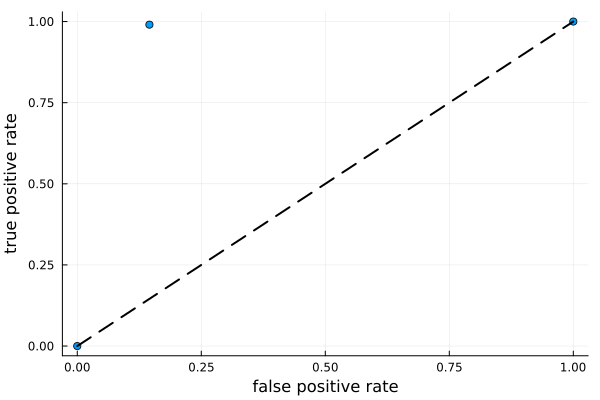

In [42]:
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree
_machine = Helper.get_machine(DecisionTreeClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_4 = Helper.get_measurements("DecisionTreeClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_4)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 5. GaussianNBClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
GaussianNBClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  priors = nothing, 
  var_smoothing = 1.0e-9)

┌ Info: Training machine(GaussianNBClassifier(priors = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("GaussianNBClassifier", 0.186, 0.884, 0.905)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     34      │      4      │
├─────────────┼─────────────┼─────────────┤
│      0      │     21      │     205     │
└─────────────┴─────────────┴─────────────┘


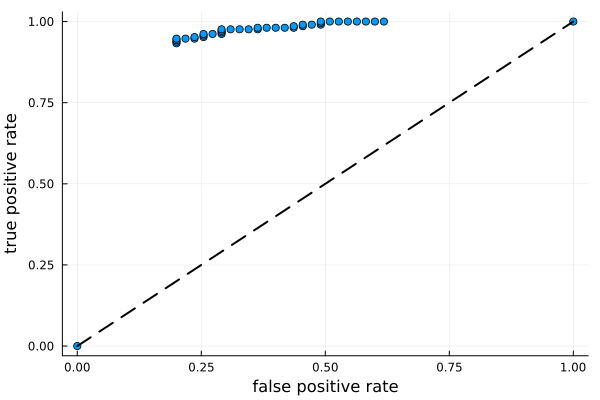

In [43]:
GaussianNBClassifier = @load GaussianNBClassifier pkg=ScikitLearn
_machine = Helper.get_machine(GaussianNBClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_5 = Helper.get_measurements("GaussianNBClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_5)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 6. KNeighborsClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
KNeighborsClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  n_neighbors = 5, 
  weights = "uniform", 
  algorithm = "auto", 
  leaf_size = 30, 
  p = 2, 
  metric = "minkowski", 
  metric_params = nothing, 
  n_jobs = nothing)

┌ Info: Training machine(KNeighborsClassifier(n_neighbors = 5, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("KNeighborsClassifier", 0.224, 0.81, 0.86)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     21      │      3      │
├─────────────┼─────────────┼─────────────┤
│      0      │     34      │     206     │
└─────────────┴─────────────┴─────────────┘


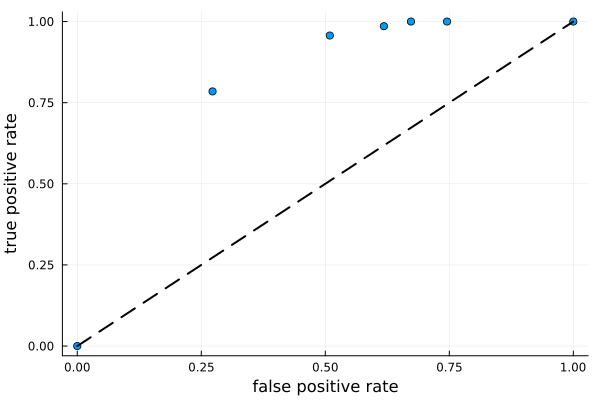

In [44]:
KNeighborsClassifier = @load KNeighborsClassifier pkg=ScikitLearn
_machine = Helper.get_machine(KNeighborsClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_6 = Helper.get_measurements("KNeighborsClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_6)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 7. LogisticClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
LogisticClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  penalty = "l2", 
  dual = false, 
  tol = 0.0001, 
  C = 1.0, 
  fit_intercept = true, 
  intercept_scaling = 1.0, 
  class_weight = nothing, 
  random_state = nothing, 
  solver = "lbfgs", 
  max_iter = 100, 
  multi_class = "auto", 
  verbose = 0, 
  warm_start = false, 
  n_jobs = nothing, 
  l1_ratio = nothing)

┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Meas("LogisticClassifier", 0.15, 0.918, 0.898)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     34      │      6      │
├─────────────┼─────────────┼─────────────┤
│      0      │     21      │     203     │
└─────────────┴─────────────┴─────────────┘


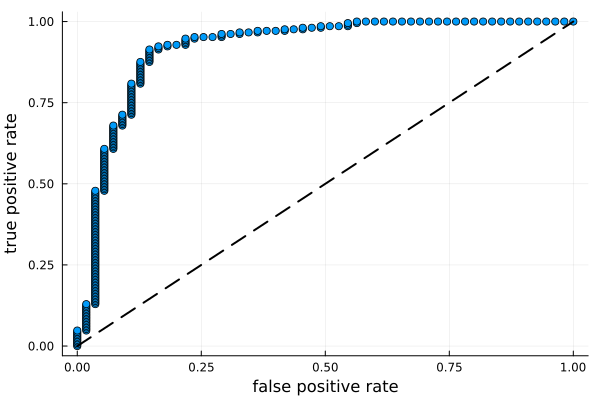

In [45]:
LogisticClassifier = @load LogisticClassifier pkg=ScikitLearn
_machine = Helper.get_machine(LogisticClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_7 = Helper.get_measurements("LogisticClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_7)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 8. GaussianProcessClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
GaussianProcessClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  kernel = nothing, 
  optimizer = "fmin_l_bfgs_b", 
  n_restarts_optimizer = 0, 
  copy_X_train = true, 
  random_state = nothing, 
  max_iter_predict = 100, 
  warm_start = false, 
  multi_class = "one_vs_rest")

┌ Info: Training machine(GaussianProcessClassifier(kernel = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("GaussianProcessClassifier", 0.495, 0.621, 0.341)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     53      │     172     │
├─────────────┼─────────────┼─────────────┤
│      0      │      2      │     37      │
└─────────────┴─────────────┴─────────────┘


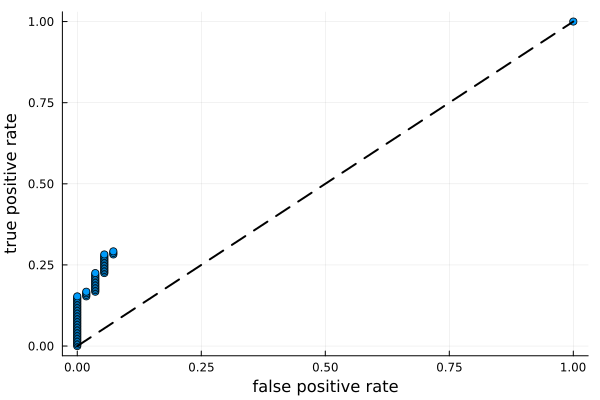

In [46]:
GaussianProcessClassifier = @load GaussianProcessClassifier pkg=ScikitLearn
_machine = Helper.get_machine(GaussianProcessClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_8 = Helper.get_measurements("GaussianProcessClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_8)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 9. ProbabilisticSGDClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
ProbabilisticSGDClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  loss = "log", 
  penalty = "l2", 
  alpha = 0.0001, 
  l1_ratio = 0.15, 
  fit_intercept = true, 
  max_iter = 1000, 
  tol = 0.001, 
  shuffle = true, 
  verbose = 0, 
  epsilon = 0.1, 
  n_jobs = nothing, 
  random_state = nothing, 
  learning_rate = "optimal", 
  eta0 = 0.0, 
  power_t = 0.5, 
  early_stopping = false, 
  validation_fraction = 0.1, 
  n_iter_no_change = 5, 
  class_weight = nothing, 
  warm_start = false, 
  average = false)

┌ Info: Training machine(ProbabilisticSGDClassifier(loss = log, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Meas("ProbabilisticSGDClassifier", 0.28, 0.804, 0.86)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     38      │     20      │
├─────────────┼─────────────┼─────────────┤
│      0      │     17      │     189     │
└─────────────┴─────────────┴─────────────┘


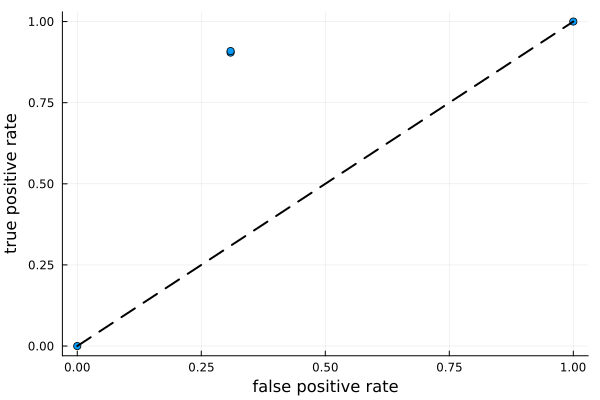

In [47]:
ProbabilisticSGDClassifier = @load ProbabilisticSGDClassifier pkg=ScikitLearn
_machine = Helper.get_machine(ProbabilisticSGDClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_9 = Helper.get_measurements("ProbabilisticSGDClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_9)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 10. RandomForestClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
RandomForestClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  n_estimators = 100, 
  criterion = "gini", 
  max_depth = nothing, 
  min_samples_split = 2, 
  min_samples_leaf = 1, 
  min_weight_fraction_leaf = 0.0, 
  max_features = "auto", 
  max_leaf_nodes = nothing, 
  min_impurity_decrease = 0.0, 
  bootstrap = true, 
  oob_score = false, 
  n_jobs = nothing, 
  random_state = nothing, 
  verbose = 0, 
  warm_start = false, 
  class_weight = nothing, 
  ccp_alpha = 0.0, 
  max_samples = nothing)

┌ Info: Training machine(RandomForestClassifier(n_estimators = 100, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Meas("RandomForestClassifier", 0.054, 0.995, 0.962)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     46      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │      9      │     208     │
└─────────────┴─────────────┴─────────────┘


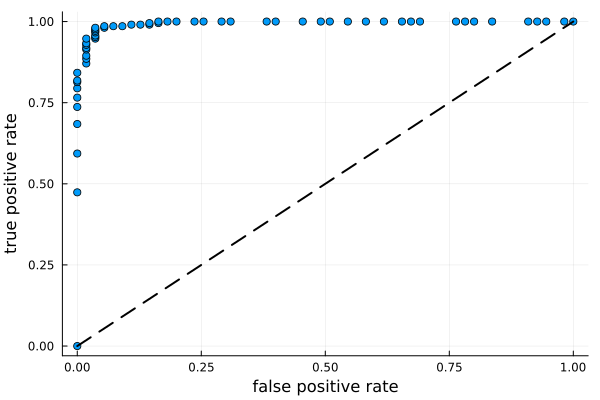

In [48]:
RandomForestClassifier = @load RandomForestClassifier pkg=ScikitLearn
_machine = Helper.get_machine(RandomForestClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_10 = Helper.get_measurements("RandomForestClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_10)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 11. BayesianQDA, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
BayesianQDA

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  priors = nothing, 
  reg_param = 0.0, 
  store_covariance = false, 
  tol = 0.0001)

┌ Info: Training machine(BayesianQDA(priors = nothing, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
/Users/fjodor/.julia/conda/3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Meas("BayesianQDA", 0.212, 0.786, 0.894)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     28      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     27      │     208     │
└─────────────┴─────────────┴─────────────┘


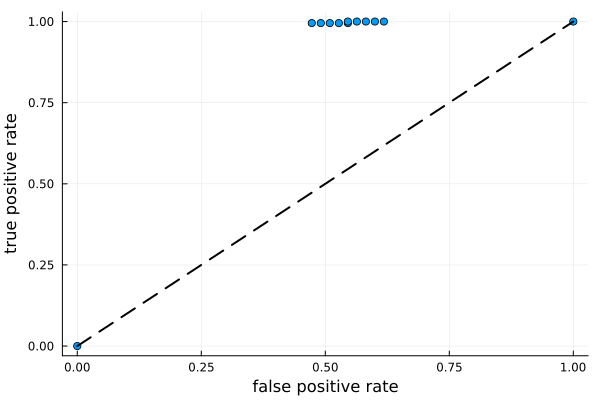

In [49]:
BayesianQDA = @load BayesianQDA pkg=ScikitLearn
_machine = Helper.get_machine(BayesianQDA(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_11 = Helper.get_measurements("BayesianQDA", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_11)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 12. DummyClassifier, package_name=ScikitLearn: parameters + evaluation

import MLJScikitLearnInterface ✔
DummyClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  strategy = "stratified", 
  constant = nothing, 
  random_state = nothing)

┌ Info: Training machine(DummyClassifier(strategy = stratified, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496


Meas("DummyClassifier", 0.553, 0.533, 0.723)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     12      │     30      │
├─────────────┼─────────────┼─────────────┤
│      0      │     43      │     179     │
└─────────────┴─────────────┴─────────────┘


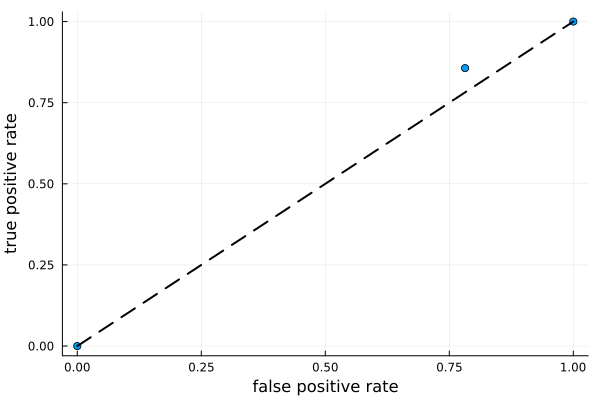

In [50]:
DummyClassifier = @load DummyClassifier pkg=ScikitLearn
_machine = Helper.get_machine(DummyClassifier(), X, y)
# evaluate: fit/predict
ŷ = Helper.fit_predict(_machine, train, validation)
# measurements:
measurements_12 = Helper.get_measurements("DummyClassifier", ŷ, y[validation], ["brier_loss", "auc", "accuracy"])
show(stdout, "text/plain", measurements_12)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
Helper.plot_roccurve(ŷ, y[validation])

#### 13. XGBoostClassifier, package_name=XGBoost: parameters + evaluation

import MLJXGBoostInterface ✔
XGBoostClassifier

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/fjodor/.julia/packages/MLJModels/47nZM/src/loading.jl:159


(
  num_round = 100, 
  booster = "gbtree", 
  disable_default_eval_metric = 0, 
  eta = 0.3, 
  gamma = 0.0, 
  max_depth = 6, 
  min_child_weight = 1.0, 
  max_delta_step = 0.0, 
  subsample = 1.0, 
  colsample_bytree = 1.0, 
  colsample_bylevel = 1.0, 
  lambda = 1.0, 
  alpha = 0.0, 
  tree_method = "auto", 
  sketch_eps = 0.03, 
  scale_pos_weight = 1.0, 
  updater = "auto", 
  refresh_leaf = 1, 
  process_type = "default", 
  grow_policy = "depthwise", 
  max_leaves = 0, 
  max_bin = 256, 
  predictor = "cpu_predictor", 
  sample_type = "uniform", 
  normalize_type = "tree", 
  rate_drop = 0.0, 
  one_drop = 0, 
  skip_drop = 0.0, 
  feature_selector = "cyclic", 
  top_k = 0, 
  tweedie_variance_power = 1.5, 
  objective = "automatic", 
  base_score = 0.5, 
  eval_metric = "mlogloss", 
  seed = 0, 
  nthread = 1)

┌ Info: Training machine(XGBoostClassifier(num_round = 100, …), …).
└ @ MLJBase /Users/fjodor/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
[1]	train-logloss:0.46355040656862323


[2]	train-logloss:0.33566870893557349
[3]	train-logloss:0.25457970814948733
[4]	train-logloss:0.19843767895423747
[5]	train-logloss:0.15953666571672862
[6]	train-logloss:0.13258186566897415
[7]	train-logloss:0.10974934901558346
[8]	train-logloss:0.09471580198083024
[9]	train-logloss:0.08219889587686434
[10]	train-logloss:0.07204522874944105
[11]	train-logloss:0.06534219716748151
[12]	train-logloss:0.05865351233159664
[13]	train-logloss:0.05287486185053630
[14]	train-logloss:0.04844212576795321
[15]	train-logloss:0.04430995419222329
[16]	train-logloss:0.04089601414411196
[17]	train-logloss:0.03891169865292122
[18]	train-logloss:0.03643063139306478
[19]	train-logloss:0.03440992353338893
[20]	train-logloss:0.03272786740646032
[21]	train-logloss:0.03152596218361785
[22]	train-logloss:0.03062913045642426
[23]	train-logloss:0.02959081303561106
[24]	train-logloss:0.02835665913578425
[25]	train-logloss:0.02740324203676375
[26]	train-logloss:0.02618421673662840
[27]	train-logloss:0.025318883850

[76]	train-logloss:0.01225971123329311
[77]	train-logloss:0.01215730871900904
[78]	train-logloss:0.01210304935852651
[79]	train-logloss:0.01203281382847556
[80]	train-logloss:0.01193728106236803
[81]	train-logloss:0.01189465240607312
[82]	train-logloss:0.01178218227392176
[83]	train-logloss:0.01170203316629435
[84]	train-logloss:0.01163701742333107
[85]	train-logloss:0.01156975233241067
[86]	train-logloss:0.01148095302410006
[87]	train-logloss:0.01143204243989758
[88]	train-logloss:0.01137466299497918
[89]	train-logloss:0.01129909117393159
[90]	train-logloss:0.01121405349587874
[91]	train-logloss:0.01111115297480156
[92]	train-logloss:0.01105830141077368
[93]	train-logloss:0.01099971269376239
[94]	train-logloss:0.01094352905028092
[95]	train-logloss:0.01089440654939537
[96]	train-logloss:0.01084452730051394
[97]	train-logloss:0.01079129512882818
[98]	train-logloss:0.01075638939725544
[99]	train-logloss:0.01071721597379240
[100]	train-logloss:0.01065930148903938


Meas("XGBoostClassifier", 0.07199999690055847, 0.9779999852180481, 0.962)
              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      0      │
├─────────────┼─────────────┼─────────────┤
│      1      │     47      │      2      │
├─────────────┼─────────────┼─────────────┤
│      0      │      8      │     207     │
└─────────────┴─────────────┴─────────────┘


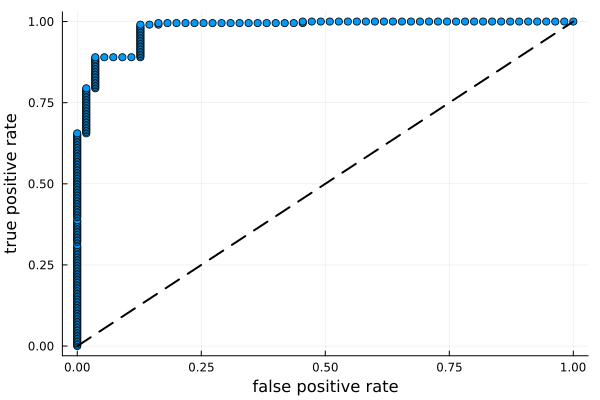

In [51]:
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost
_machine = Helper.get_machine(XGBoostClassifier(), X, y)
# evaluate: fit/predict
fit!(_machine, rows=train)
ŷ = predict(_machine, rows=validation)
# measurements:
measurements_13 = Helper.Meas("XGBoostClassifier", 0.0, 0.0, 0.0)
mt = ["brier_loss", "auc", "accuracy"]
if "brier_loss" ∈ mt
    measurements_13.brier_loss = round(brier_loss(ŷ, y[validation]) |> mean, digits=3)
end
if "auc" ∈ mt
    measurements_13.auc = round(auc(ŷ, y[validation]), digits=3)
end
if "accuracy" ∈ mt
    measurements_13.accuracy = round(accuracy(mode.(ŷ), y[validation]), digits=3)
end
show(stdout, "text/plain", measurements_13)
println()
# confusion matrix
show(stdout, "text/plain", confmat(mode.(ŷ), y[validation]))
# plot roc curve
roc_curve = roc(ŷ, y[validation])
plt = scatter(roc_curve, legend=false)
plot!(plt, xlab="false positive rate", ylab="true positive rate")
plot!([0, 1], [0, 1], linewidth=2, linestyle=:dash, color=:black)

### Baseline selection

#### Measures received by algorithm

In [52]:
Helper.get_meas_as_tuple(measurements_1)

("AdaBoostClassifier", 0.257, 0.955, 0.966)

In [53]:
measurements = vcat(
    Helper.get_meas_as_tuple(measurements_1), 
    Helper.get_meas_as_tuple(measurements_2),
    Helper.get_meas_as_tuple(measurements_3),
    Helper.get_meas_as_tuple(measurements_4),
    Helper.get_meas_as_tuple(measurements_5),
    Helper.get_meas_as_tuple(measurements_6),
    Helper.get_meas_as_tuple(measurements_7),
    Helper.get_meas_as_tuple(measurements_8),
    Helper.get_meas_as_tuple(measurements_9),
    Helper.get_meas_as_tuple(measurements_10),
    Helper.get_meas_as_tuple(measurements_11),
    Helper.get_meas_as_tuple(measurements_12),
    Helper.get_meas_as_tuple(measurements_13)
)
typeof(measurements)

# Ref, inspired by: https://discourse.julialang.org/t/dataframe-construction-from-array-of-tuples/11426/7
m_df = DataFrame(NamedTuple{(:model, :brier_loss, :auc, :accuracy)}.(measurements))
sort!(m_df, [:brier_loss], rev=false)

,model,brier_loss,auc,accuracy
,String,Float64,Float64,Float64
1,BaggingClassifier,0.036,0.977,0.981
2,RandomForestClassifier,0.054,0.995,0.962
3,XGBoostClassifier,0.072,0.978,0.962
4,DecisionTreeClassifier,0.076,0.951,0.962
5,LogisticClassifier,0.15,0.918,0.898
6,GaussianNBClassifier,0.186,0.884,0.905
7,BayesianQDA,0.212,0.786,0.894
8,KNeighborsClassifier,0.224,0.81,0.86
9,BayesianLDA,0.253,0.84,0.848


#### Baseline selected

In [54]:
m_df[1, :]

,model,brier_loss,auc,accuracy
,String,Float64,Float64,Float64
1,BaggingClassifier,0.036,0.977,0.981


### Save the baseline

In [55]:
CSV.write(joinpath(@__DIR__, "data/baseline/baseline.csv"), delim=';', DataFrame(m_df[1, :]))

"/Volumes/Data Science 214386/DataScience214386/LTAT.02.023 - Explainable Automated Machine Learning/project-1/data/baseline/baseline.csv"